# GAN手写数字Pytorch实现
- @author: shenhao0223sh@gmail.com
- Date: 2021.10.22

In [1]:
from google.colab import drive  # Import a library named google.colab

drive.mount(
    "/content/drive", force_remount=True
)  # mount the content to the directory `/content/drive`

Mounted at /content/drive


In [2]:
import os

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

In [3]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyper-parameters
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 200
batch_size = 100
sample_dir = "samples"

# Create a directory if not exists
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# Image processing
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean=0.5, std=0.5)]
)

# MNIST dataset
mnist = torchvision.datasets.MNIST(
    "./data", train=True, transform=transform, download=True
)

# Data loader
data_loader = torch.utils.data.DataLoader(
    dataset=mnist, batch_size=batch_size, shuffle=True
)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
# 构建判断器
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid(),
)

D = D.to(device)

In [5]:
# 构建生成器
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh(),
)

G = G.to(device)

In [6]:
# 定义损失函数以及优化器
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)


def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)


def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()


# Start training
total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)

        # 定义图像是真或假的标签
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        # ================================================================== #
        #                          训练判别器                                 #
        # ================================================================== #
        # 定义判别器对真图像的损失函数
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # 定义判别器对假图像（即由潜在空间点生成的图像）的损失函数
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        # 得到判别器总的损失函数
        d_loss = d_loss_real + d_loss_fake

        # 对生成器、判别器的梯度清零
        # 进行反向传播及运行判别器的优化器
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        # ================================================================== #
        #                           训练生成器                                #
        # ================================================================== #
        # 定义生成器对假图像的损失函数
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)

        g_loss = criterion(outputs, real_labels)

        # 对生成器、判别器的梯度清零
        # 进行反向传播及运行生成器的优化器
        reset_grad()
        g_loss.backward()
        g_optimizer.step()

        if (i + 1) % 200 == 0:
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                    epoch,
                    num_epochs,
                    i + 1,
                    total_step,
                    d_loss.item(),
                    g_loss.item(),
                    real_score.mean().item(),
                    fake_score.mean().item(),
                )
            )

    # 保存真图像
    if (epoch + 1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, "real_images.png"))

    # 保存假图像
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(
        denorm(fake_images),
        os.path.join(sample_dir, "fake_images-{}.png".format(epoch + 1)),
    )

# 保存模型
torch.save(G.state_dict(), "G.ckpt")
torch.save(D.state_dict(), "D.ckpt")

Epoch [0/200], Step [200/600], d_loss: 0.0613, g_loss: 4.0422, D(x): 0.99, D(G(z)): 0.05
Epoch [0/200], Step [400/600], d_loss: 0.1176, g_loss: 6.1782, D(x): 0.97, D(G(z)): 0.03
Epoch [0/200], Step [600/600], d_loss: 0.0233, g_loss: 5.8238, D(x): 0.99, D(G(z)): 0.01
Epoch [1/200], Step [200/600], d_loss: 0.0292, g_loss: 5.8409, D(x): 0.99, D(G(z)): 0.02
Epoch [1/200], Step [400/600], d_loss: 0.3582, g_loss: 2.9639, D(x): 0.95, D(G(z)): 0.24
Epoch [1/200], Step [600/600], d_loss: 0.0151, g_loss: 5.7163, D(x): 1.00, D(G(z)): 0.01
Epoch [2/200], Step [200/600], d_loss: 0.0747, g_loss: 4.7393, D(x): 0.97, D(G(z)): 0.04
Epoch [2/200], Step [400/600], d_loss: 0.1786, g_loss: 4.0599, D(x): 0.93, D(G(z)): 0.06
Epoch [2/200], Step [600/600], d_loss: 1.1071, g_loss: 2.9534, D(x): 0.73, D(G(z)): 0.30
Epoch [3/200], Step [200/600], d_loss: 0.7829, g_loss: 2.9803, D(x): 0.71, D(G(z)): 0.12
Epoch [3/200], Step [400/600], d_loss: 0.1425, g_loss: 4.0530, D(x): 0.97, D(G(z)): 0.11
Epoch [3/200], Step [

In [7]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

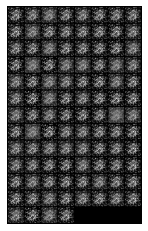

In [8]:
reconsPath = "./samples/fake_images-1.png"
Image = mpimg.imread(reconsPath)
plt.imshow(Image)
plt.axis("off")
plt.show()

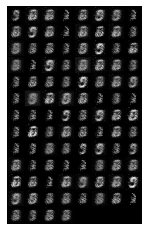

In [9]:
reconsPath = "./samples/fake_images-10.png"
Image = mpimg.imread(reconsPath)
plt.imshow(Image)
plt.axis("off")
plt.show()

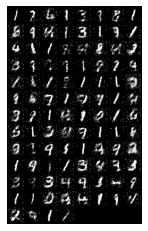

In [10]:
reconsPath = "./samples/fake_images-50.png"
Image = mpimg.imread(reconsPath)
plt.imshow(Image)
plt.axis("off")
plt.show()

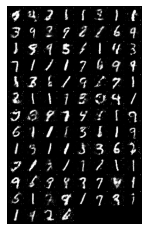

In [11]:
reconsPath = "./samples/fake_images-100.png"
Image = mpimg.imread(reconsPath)
plt.imshow(Image)
plt.axis("off")
plt.show()

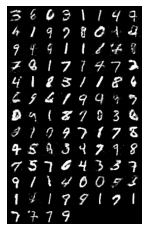

In [12]:
reconsPath = "./samples/fake_images-200.png"
Image = mpimg.imread(reconsPath)
plt.imshow(Image)
plt.axis("off")
plt.show()